In [8]:
# !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cpu.html
# !pip install torch torchvision torchaudio 
# !pip install sklearn numpy matplotlib

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [9]:
# 1. import Python standard built-in modules
import os

# 2. import 3rd party libraries
# data science libs
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns

# deep learning/AI libs
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

import torch.nn.functional as F
import torch.nn as nn
# from torch.nn import Linear, ReLU


from torch_geometric.data import Data

# 3. import local modules
# from models import *
import models as my_models # known that these are my model


1.12.0


In [10]:
# 固定 the random number so that the experiments are reproducible 
# 同一次kernel运行 不重启，实验结果是可复现的
# random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

## Data & preprocess

In [11]:
Edges_train = pd.read_excel('graph10.xlsx', sheet_name= 'Sheet2')
Edges_test = pd.read_excel('graph10.xlsx', sheet_name= 'Sheet4')
Edges_validation = pd.read_excel('graph10.xlsx', sheet_name= 'Sheet6')

dataset_train = pd.read_excel('graph10.xlsx', sheet_name= 'Train2')
dataset_test = pd.read_excel('graph10.xlsx', sheet_name = 'Test2')
dataset_validation = pd.read_excel('graph10.xlsx', sheet_name= 'Validation')

#one_hot_cols = pd.get_dummies(dataset_train['Flat Type'], prefix='Flat')
#dataset_train = dataset_train.drop(columns=['Flat Type'])
#dataset_train = pd.concat([one_hot_cols, dataset_train], axis=1)

#one_hot_cols = pd.get_dummies(dataset_test['Flat Type'], prefix='Flat')
#dataset_test = dataset_test.drop(columns=['Flat Type'])
#dataset_test = pd.concat([one_hot_cols, dataset_test], axis=1)

#one_hot_cols = pd.get_dummies(dataset_train['Room Type'], prefix='Room')
#dataset_train = dataset_train.drop(columns=['Room Type'])
#dataset_train = pd.concat([one_hot_cols, dataset_train], axis=1)

#one_hot_cols = pd.get_dummies(dataset_test['Room Type'], prefix='Room')
#dataset_test = dataset_test.drop(columns=['Room Type'])
#dataset_test = pd.concat([one_hot_cols, dataset_test], axis=1)

# one_hot_cols = pd.get_dummies(dataset_train['Wing Orientation'], prefix='Wing')
# dataset_train = dataset_train.drop(columns=['Wing Orientation'])
# dataset_train = pd.concat([one_hot_cols, dataset_train], axis=1)

# one_hot_cols = pd.get_dummies(dataset_test['Wing Orientation'], prefix='Wing')
# dataset_test = dataset_test.drop(columns=['Wing Orientation'])
# dataset_test = pd.concat([one_hot_cols, dataset_test], axis=1)

# one_hot_cols = pd.get_dummies(dataset_train['Flat Orientation'], prefix='Flat Orientation')
# dataset_train = dataset_train.drop(columns=['Flat Orientation'])
# dataset_train = pd.concat([one_hot_cols, dataset_train], axis=1)

# one_hot_cols = pd.get_dummies(dataset_test['Flat Orientation'], prefix='Flat Orientation')
# dataset_test = dataset_test.drop(columns=['Flat Orientation'])
# dataset_test = pd.concat([one_hot_cols, dataset_test], axis=1)

dataset_train.fillna(0, inplace=True)
dataset_test.fillna(0, inplace=True)
dataset_validation.fillna(0, inplace=True)

train_X = dataset_train.iloc[0:, :15]
train_Y = dataset_train.iloc[0:, 15:]

test_X = dataset_test.iloc[0:, :15]
test_Y = dataset_test.iloc[0:, 15:]

validation_X = dataset_validation.iloc[0:, :15]
validation_Y = dataset_validation.iloc[0:, 15:]

scalerX = StandardScaler().fit(train_X)
scalerY = StandardScaler().fit(train_Y)
train_X = scalerX.transform(train_X)
train_Y = scalerY.transform(train_Y)
test_X = scalerX.transform(test_X)
test_Y = scalerY.transform(test_Y)

validation_X = scalerX.transform(validation_X)
validation_Y = scalerY.transform(validation_Y)

edges_train = Edges_train.values - 1
edges_train = torch.from_numpy(edges_train).t()
edges_train = edges_train.long()

edges_test = Edges_test.values - 1
edges_test = torch.from_numpy(edges_test).t()
edges_test = edges_test.long()

edges_validation = Edges_validation.values - 1
edges_validation = torch.from_numpy(edges_validation).t()
edges_validation = edges_validation.long()

train = pd.concat([pd.DataFrame(train_X), pd.DataFrame(train_Y)], axis=1)
test = pd.concat([pd.DataFrame(test_X), pd.DataFrame(test_Y)], axis=1)
validation = pd.concat([pd.DataFrame(validation_X), pd.DataFrame(validation_Y)], axis=1)

train_X = torch.tensor(np.array(train_X.astype('f')))
train_Y = torch.tensor(np.array(train_Y.astype('f')))

test_X = torch.tensor(np.array(test_X.astype('f')))
test_Y = torch.tensor(np.array(test_Y.astype('f')))

validation_X = torch.tensor(np.array(validation_X.astype('f')))
validation_Y = torch.tensor(np.array(validation_Y.astype('f')))


train_data = Data(x = train_X, edge_index = edges_train, y = train_Y)
test_data = Data(x = test_X, edge_index = edges_test, y = test_Y)
val_data = Data(x = validation_X, edge_index = edges_validation, y = validation_Y)

# ACH_MEAN = dataset_train.ACH.mean()
# ACH_var = dataset_train.ACH.var()
# ACH_Min = dataset_train.ACH.min()
# ACH_Max = dataset_train.ACH.max()
# CP_MEAN = dataset_train.CP.mean()
# CP_var = dataset_train.CP.var()
# CP_Min = dataset_train.CP.min()
# CP_Max = dataset_train.CP.max()


train_Y_mean = train_Y.mean()
train_Y_var = train_Y.var()


## Model define(写在 和参数一起了)

## Model training/evaluation

In [36]:
# 构造模型
model = my_models.GCN1()

# 学习优化器
learning_rate = 8e-4 # TODO 降低，模型太好了，收敛过快！
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# 损失函数
# criterion = torch.nn.MSELoss()
loss_f = torch.nn.HuberLoss(reduction='mean', delta=0.15)

# 设置训练网络的参数
# 记录 epoch loss
train_losses = []
val_losses = []


# ====== 未使用到的参数 =======
# 训练【总的】次数 - 用于整个训练的画图
train_step = 0
# 测试【总的】次数 - 用于整个训练的画图
val_step = 0
# training hyper params
batch_size = 100 # 未使用到


# 训练轮数
epoch = 1000

def draw_loss(train_losses, val_losses):
  plt.figure()
  plt.title('loss',fontsize=15)
  plt.plot(train_losses,'-')
  plt.plot(val_losses,'-')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['Train','Eval/Test'])
  plt.show


=======Totally train 1000 epochs=======
-------100th epoch-------
train loss: 0.0134, acc: 0.8207 | val loss: 0.006106, acc: 0.916667
-------200th epoch-------
train loss: 0.0099, acc: 0.8739 | val loss: 0.004974, acc: 0.888889
-------300th epoch-------
train loss: 0.0077, acc: 0.9085 | val loss: 0.002870, acc: 0.944444
-------400th epoch-------
train loss: 0.0061, acc: 0.9207 | val loss: 0.005575, acc: 0.944444
-------500th epoch-------
train loss: 0.0052, acc: 0.9133 | val loss: 0.001815, acc: 1.000000
-------600th epoch-------
train loss: 0.0037, acc: 0.9351 | val loss: 0.001200, acc: 1.000000
-------700th epoch-------
train loss: 0.0029, acc: 0.9367 | val loss: 0.003121, acc: 0.972222
-------800th epoch-------
train loss: 0.0028, acc: 0.9394 | val loss: 0.003445, acc: 0.972222
-------900th epoch-------
train loss: 0.0021, acc: 0.9574 | val loss: 0.001204, acc: 1.000000
-------1000th epoch-------
train loss: 0.0021, acc: 0.9564 | val loss: 0.001664, acc: 0.972222


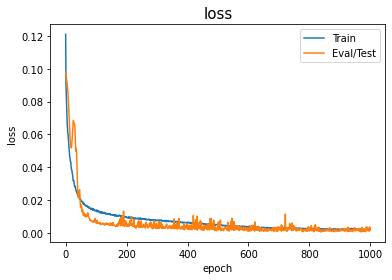

In [37]:
# 记录 epoch loss for plotting
train_losses = []
test_losses = []

print(f'=======Totally train {epoch} epochs=======')
for epoch_no in range(epoch):
    
    # 训练步骤开始
    # 以防万一有BatchNorm和Dropout, 加上就好
    model.train()
  
    # 优化器graient清零
    optimizer.zero_grad()
    
    train_output = model(train_data.x, train_data.edge_index)
    train_loss = loss_f(train_output, train_data.y)

    # 反向传播，更新参数
    train_loss.backward()
    optimizer.step()
    
    # record
    train_losses.append(train_loss.data)
    
    # if (epoch_no+1) % (epoch/10) == 0:
        # print("-------{}th epoch-------".format(epoch_no+1))
        # train_correct = abs((train_output - train_data.y)/train_output) < 0.25  # Check against ground-truth labels.
        # train_acc = int(train_correct.sum()) / len(train_output)
        
        # print("train loss: {:.5f}, acc: {:.5f}".format(train_loss.data, train_acc))
        # writer.add_scalar("train_bt_loss", loss.data, train_step)
    
    
    # 以防万一有，BatchNorm和Dropout, 加上就好
    model.eval()
    
    # TODO 以下均为epoch为单位
    # val_loss_epoch = 0 # 单独记下整个epoch的val loss
    # val_correct_epoch = 0 # 为了最后，计算总的 acc
    
    with torch.no_grad(): # freeze gradient
      
        # val_output = model(test_data.x, test_data.edge_index)
        # val_loss = loss_f(val_output, test_data.y)
        val_output = model(val_data.x, val_data.edge_index)
        val_loss = loss_f(val_output, val_data.y)
        
        # record
        val_losses.append(val_loss.data)
        # val_loss_total += val_loss.data
        # val_step = val_step + 1

    # ===========一个epoch 算一次 ============
    if (epoch_no+1) % (epoch/10) == 0:
        print("-------{}th epoch-------".format(epoch_no+1))
        # 统计 epoch的 acc
        train_correct = abs((train_output - train_data.y)/train_output) < 0.25  # Check against ground-truth labels.
        train_acc = int(train_correct.sum()) / len(train_output)
        
        val_correct = abs((val_output - val_data.y)/val_output) < 0.25  # Check against ground-truth labels.
        val_acc = int(val_correct.sum()) / len(val_output)
        
        print("train loss: {:.4f}, acc: {:.4f}".format(train_loss.data, train_acc) + 
              " | val loss: {:4f}, acc: {:4f}".format(val_loss.data, val_acc))
    

        # 保存当前epoch的model参数    
        torch.save(model, f"model_pth/{model.__class__.__name__}_ep{epoch_no+1}.pth")
        # print(f"epoch{epoch_no+1}: 模型已保存")
    
draw_loss(train_losses, val_losses)


## Prediction预测真实数据，并输出

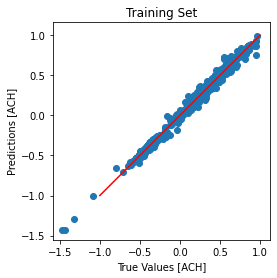

In [16]:
model.eval()
train_predictions = model(train_data.x, train_data.edge_index)
# train_predictions = model(train_data.x)
train_predictions_inverse = scalerY.inverse_transform(train_predictions.detach().cpu().numpy())
train_Y_inverse = scalerY.inverse_transform(train_Y)

prediction_frame = pd.DataFrame(train_predictions_inverse, index=dataset_train.index)
test_2 = pd.concat([pd.DataFrame(test_X), pd.DataFrame(train_Y)], axis=1)
result = pd.concat([test_2, prediction_frame], axis=1)
result.rename(columns={0:'Prediction'},inplace = True)
# result = test.join(prediction_frame)
# pd.merge(test, prediction_frame, left_index=True)
result.to_csv('result_Analysis_MAE_train.csv')

writer = pd.ExcelWriter('result_analysis_train.xlsx')
result.to_excel(writer, 'Sheet1')
writer.save()

fig = plt.figure()
plt.title('Training Set')
plt.scatter(train_Y_inverse, train_predictions_inverse)
plt.xlabel('True Values [ACH]')
plt.ylabel('Predictions [ACH]')
x = np.linspace(-1,1)
y = x
plt.plot(x, y, '-r', label='y=x')
plt.axis('equal')
plt.axis('square')
# plt.show()
fig.set_size_inches(6, 4)
fig.savefig('Training set.png', dpi=fig.dpi)
# plt.xlim([-0.1, 55])
# plt.ylim([-0.1, 55])
# _ = plt.plot([-100, 100], [-100, 100])

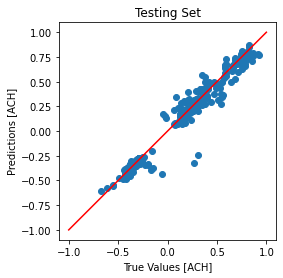

In [24]:
model.eval()
test_predictions = model(test_data.x, test_data.edge_index)
# test_predictions = model(test_data.x)
test_predictions_inverse = scalerY.inverse_transform(test_predictions.detach().cpu().numpy())
test_Y_inverse = scalerY.inverse_transform(test_Y)
prediction_frame = pd.DataFrame(test_predictions_inverse, index=dataset_test.index)
# test_2 = pd.concat([pd.DataFrame(test_X.detach().numpy()), pd.DataFrame(test_Y.detach().numpy())], axis=1)
result = pd.concat([dataset_test, prediction_frame], axis=1)
result.rename(columns={0:'Prediction'},inplace = True)
# result = test.join(prediction_frame)
# pd.merge(test, prediction_frame, left_index=True)
result.to_csv('result_Analysis_MAE.csv')

writer = pd.ExcelWriter('result_analysis.xlsx')
result.to_excel(writer, 'Sheet1')
writer.save()

fig = plt.figure()
plt.title('Testing Set')
plt.scatter(test_Y_inverse, test_predictions_inverse)
plt.xlabel('True Values [ACH]')
plt.ylabel('Predictions [ACH]')
x = np.linspace(-1,1)
y = x
plt.plot(x, y, '-r', label='y=x')
plt.axis('equal')
plt.axis('square')
# plt.show()
fig.set_size_inches(6, 4)
fig.savefig('MAE.png', dpi=fig.dpi)
# plt.xlim([-0.1, 55])
# plt.ylim([-0.1, 55])
# _ = plt.plot([-100, 100], [-100, 100])

In [25]:
def train_and_pred(validation_data, validation_labels):
  model.cpu()
  preds = model(validation_data.x, validation_data.edge_index)
  preds = scalerY.inverse_transform(preds.detach().numpy())
  validation_labels['Cp'] = pd.Series(preds[:,0].reshape(1, -1)[0])
  submission = pd.concat([validation_labels['Id'], validation_labels['Cp']], axis=1)
  submission.to_csv('./Validation Results.csv', index=False)

In [26]:
validation_labels = pd.DataFrame(scalerY.inverse_transform(validation_Y.detach().numpy()))
validation_labels.columns = ['Id']
train_and_pred(val_data, validation_labels)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def drawComparison (ACH, PRED):
    fig = plt.figure()
    plt.title('Testing Set', FontSize=24)
    plt.scatter(ACH, PRED)
    plt.xlabel('True Values [ACH]', FontSize=24)
    plt.ylabel('Predictions [ACH]', FontSize=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    x = np.linspace(-5,60,20)
    y = x
    plt.plot(x, y, '-r', label='y=x')
    plt.axis('equal')
    plt.axis('square')

    fig.set_size_inches(16, 9)
    fig.savefig('comparison', dpi=fig.dpi)

MAE = pd.read_csv('result_Analysis_MAE.csv')
# ACH_MAE = MAE['ACH']
ACH_MAE = MAE['W1 Cp']
PRED_MAE = MAE['Prediction']
absolute_diff_MAE = abs(ACH_MAE-PRED_MAE)
absolute_percentage_diff_MAE = abs(ACH_MAE-PRED_MAE)/abs(ACH_MAE)
drawComparison(ACH_MAE, PRED_MAE)

# Rating_GT = MAE['ACH']
# Rating_Pred = MAE['ACH']
# is_equal = MAE['ACH']
Rating_GT = MAE['W1 Cp']
Rating_Pred = MAE['W1 Cp']
is_equal = MAE['W1 Cp']

Output = pd.concat([ACH_MAE, PRED_MAE, absolute_diff_MAE, 
                    absolute_percentage_diff_MAE, Rating_GT, Rating_Pred, is_equal],axis=1,ignore_index=True)
# Output.columns=['ACH','PRED_MAE','absolute_diff_MAE',
                              # 'absolute_percentage_diff_MAE','Rating_GT', 'Rating_Pred']

Output.columns=['ACH','PRED_MAE','absolute_diff_MAE',
                              'absolute_percentage_diff_MAE','Rating_GT', 'Rating_Pred','is_equal']

# Output.loc[Output['ACH'] <=5, 'Rating_GT'] = 0
# Output.loc[(Output['ACH'] >5) & (Output['ACH'] <=10), 'Rating_GT'] = 1
# Output.loc[(Output['ACH'] >10) & (Output['ACH'] <=30), 'Rating_GT'] = 2
# Output.loc[(Output['ACH'] >30) & (Output['ACH'] <=70), 'Rating_GT'] = 3
# # Output.loc[(Output['ACH'] >44) & (Output['ACH'] <=70), 'Rating_GT'] = 4
# Output.loc[Output['ACH'] >70, 'Rating_GT'] = 4

# Output.loc[Output['PRED_MAE'] <=5, 'Rating_Pred'] = 0
# Output.loc[(Output['PRED_MAE'] >5) & (Output['PRED_MAE'] <=10), 'Rating_Pred'] = 1
# Output.loc[(Output['PRED_MAE'] >10) & (Output['PRED_MAE'] <=30), 'Rating_Pred'] = 2
# Output.loc[(Output['PRED_MAE'] >30) & (Output['PRED_MAE'] <=70), 'Rating_Pred'] = 3
# # Output.loc[(Output['PRED_MAE'] >44) & (Output['PRED_MAE'] <=70), 'Rating_Pred'] = 4
# Output.loc[Output['PRED_MAE'] >70, 'Rating_Pred'] = 4

# Output.loc[Output['ACH'] <=4, 'Rating_GT'] = 0
# Output.loc[(Output['ACH'] >4) & (Output['ACH'] <=8), 'Rating_GT'] = 1
# Output.loc[(Output['ACH'] >8) & (Output['ACH'] <=16), 'Rating_GT'] = 2
# Output.loc[Output['ACH'] >16, 'Rating_GT'] = 3
# Output.loc[Output['PRED_MAE'] <=4, 'Rating_Pred'] = 0
# Output.loc[(Output['PRED_MAE'] >4) & (Output['PRED_MAE'] <=8), 'Rating_Pred'] = 1
# Output.loc[(Output['PRED_MAE'] >8) & (Output['PRED_MAE'] <=16), 'Rating_Pred'] = 2
# Output.loc[Output['PRED_MAE'] >16, 'Rating_Pred'] = 3

# Output.loc[Output['Rating_GT'] == Output['Rating_Pred'], 'is equal'] = 1
# count_Pred = Output['Rating_Pred'].value_counts()
# count_GT = Output['Rating_GT'].value_counts()

Output.to_csv('PaperResult.csv')

KeyError: 'W1 Cp'

In [ ]:
true_count = 0
total_count = len(Output['Rating_GT'])
for i in range(total_count):
  if Output['Rating_GT'].iloc[i] == Output['Rating_Pred'].iloc[i]:
    true_count += 1
true_percent = true_count/total_count

print(true_percent)

NameError: ignored